In [1]:
import matplotlib 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helper import *
from tqdm import tqdm_notebook
import brainconn as bc
import pandas as pd
import seaborn as sns
import nilearn.plotting as plotting
import palettable as pal
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import scipy.stats as stats

In [2]:
conn_mat, labels, dist_mat, g_conn = load_marmoset_data()
comm_res = load_pickle_file('data/modularity_20181127_223655.pickle')
[conn_rc, randmat_rc, randmat_rc_mean,
 conn_rc_ratio, p_vals, p_sig_index] = load_pickle_file('data/modularity_20181127_231430.pickle')
output_dir = "./figures-v2/"

In [5]:
cmap_seq2 = mcolors.LinearSegmentedColormap.from_list('',
                                                      pal.cmocean.sequential.Deep_20.mpl_colors[4:-4])
cmap_seq2_r = mcolors.LinearSegmentedColormap.from_list('',
                                                      list(reversed(pal.cmocean.sequential.Deep_20.mpl_colors[4:-4])))

In [3]:
comm_gamma_list = comm_res['comm_gamma_list']
norm_mut_info_mat = comm_res['norm_mut_info_mat']

comm_pc_mat_in = np.zeros((len(conn_mat), len(comm_gamma_list)))
comm_pc_mat_out = np.zeros((len(conn_mat), len(comm_gamma_list)))

In [4]:
for idx, (gamma, consen) in enumerate(comm_gamma_list):
    particip_coeff_in = bc.centrality.participation_coef(conn_mat, consen, degree='in')
    particip_coeff_out = bc.centrality.participation_coef(conn_mat, consen, degree='out')
    pc_in_rank = stats.rankdata([-1 * _ for _ in particip_coeff_in])
    pc_out_rank = stats.rankdata([-1 * _ for _ in particip_coeff_out])
    comm_pc_mat_in[:, idx] = pc_in_rank
    comm_pc_mat_out[:, idx] = pc_out_rank

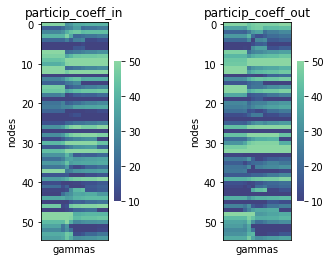

In [6]:
fig, axes = plt.subplots(1, 2)

im1 = axes[0].imshow(comm_pc_mat_in, cmap=cmap_seq2_r, aspect='equal', interpolation='nearest')
axes[0].set_xlabel('gammas')
axes[0].set_ylabel('nodes')
axes[0].set_title('particip_coeff_in')
im1.set_clim(10, 50)
axes[0].set_xticks([])
cb = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cb.outline.set_visible(False)

im2 = axes[1].imshow(comm_pc_mat_out, cmap=cmap_seq2_r, aspect='equal', interpolation='nearest')
axes[1].set_title('particip_coeff_out')
axes[1].set_xlabel('gammas')
axes[1].set_ylabel('nodes')
im2.set_clim(10, 50)
axes[1].set_xticks([])
cb = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cb.outline.set_visible(False)


In [9]:
comm_pc_mat_in_val = np.zeros((len(conn_mat), len(comm_gamma_list)))
comm_pc_mat_out_val = np.zeros((len(conn_mat), len(comm_gamma_list)))
for idx, (gamma, consen) in enumerate(comm_gamma_list):
    particip_coeff_in = bc.centrality.participation_coef(conn_mat, consen, degree='in')
    particip_coeff_out = bc.centrality.participation_coef(conn_mat, consen, degree='out')
    comm_pc_mat_in_val[:, idx] = particip_coeff_in
    comm_pc_mat_out_val[:, idx] = particip_coeff_out

Text(0.5, 1.0, 'particip_coeff_out for gamma=0.8')

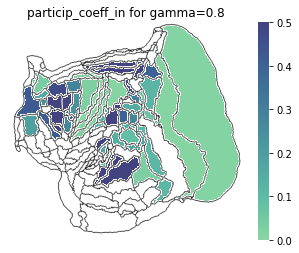

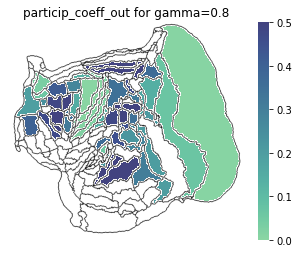

In [10]:
consen_val1 = 0.8
consen_idx_1 = [it for it, _ in enumerate(comm_gamma_list) if np.isclose(_[0], consen_val1)][0]

fig, ax, cb = plot_flatmap(comm_pc_mat_in_val[:, consen_idx_1], cmap=cmap_seq2, vmin=0, vmax=0.5)
plt.title(f'particip_coeff_in for gamma={consen_val1}')

fig, ax, cb = plot_flatmap(comm_pc_mat_out_val[:, consen_idx_1], cmap=cmap_seq2, vmin=0, vmax=0.5)
plt.title(f'particip_coeff_out for gamma={consen_val1}')

Text(0.5, 1.0, 'Rich club analysis for the network')

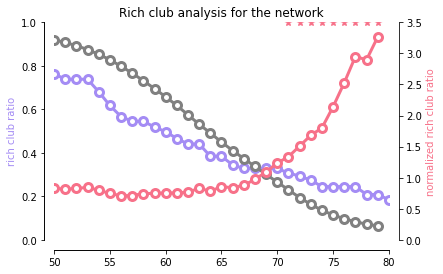

In [11]:
disc_pal_4 = sns.color_palette("husl", 4)

fig, ax1 = plt.subplots()
ax1.plot(conn_rc, marker='o', markersize=8, markeredgewidth=3,
         linestyle='-', color=disc_pal_4[-1], linewidth=3,
         markeredgecolor=disc_pal_4[-1], markerfacecolor='white')
ax1.plot(randmat_rc_mean, marker='o', markersize=8, markeredgewidth=3,
         linestyle='-', color='gray', linewidth=3,
         markeredgecolor='gray', markerfacecolor='white')
ax1.set_ylabel('rich club ratio')
ax1.yaxis.label.set_color(disc_pal_4[-1])
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.plot(conn_rc_ratio, marker='o', markersize=8, markeredgewidth=3,
         linestyle='-', color=disc_pal_4[0], linewidth=3,
         markeredgecolor=disc_pal_4[0], markerfacecolor='white')
ax2.set_ylabel('normalized rich club ratio')
ax2.yaxis.label.set_color(disc_pal_4[0])
ax2.set_ylim(0, 3.5)

p_sig_index_plot = (np.array([_ for _ in p_sig_index[0] if _ <80]), )
plt.plot(p_sig_index_plot, [3.5] * len(p_sig_index_plot), marker='*', markersize=8, color=disc_pal_4[0])
plt.xlim(50, 80)

sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False, offset=10, trim=True)
sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False, offset=10, trim=True)

# plt.xlabel('node degree')
plt.title('Rich club analysis for the network')

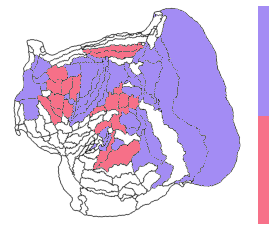

In [12]:
g_conn_degrees = list(nx.degree(g_conn))
# get rc nodes
rich_club_thres = 80
g_conn_rc_nodes = [_[0] for _ in g_conn_degrees if _[1] >= rich_club_thres]
g_conn_non_rc_nodes = [_ for _ in list(g_conn) if _ not in g_conn_rc_nodes]
# get rc edges
g_conn_edges = list(nx.edges(g_conn))
g_conn_rc_edges = [_ for _ in g_conn_edges if _[0] in g_conn_rc_nodes and _[1] in g_conn_rc_nodes]
g_conn_local_edges = [_ for _ in g_conn_edges if _[0] in g_conn_non_rc_nodes and _[1] in g_conn_non_rc_nodes]
g_conn_feeder_edges = [_ for _ in g_conn_edges if _ not in g_conn_rc_edges and _ not in g_conn_local_edges]

color_assign = [1 if _ in g_conn_rc_nodes else 2 for _ in range(55)]

imshow_cmap = mcolors.ListedColormap([disc_pal_4[0], disc_pal_4[-1]])
bounds=[0.5,1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, imshow_cmap.N)

fig, ax, cb = plot_flatmap(color_assign, interpolation='nearest', cmap=imshow_cmap, norm=norm)
cb.set_ticks([])

In [13]:
", ".join([labels[_] for _ in g_conn_rc_nodes])

'A23a, A23b, A45, A47L, A6DC, A6DR, A6Va, A8aD, A8aV, A8b, AIP, AuCM, MST, OPt, PFG, PG, S2E, TE3, TPO'

In [14]:
", ".join([labels[_] for _ in g_conn_non_rc_nodes])

'A1-2, A10, A11, A19DI, A19M, A23c, A24d, A32, A32V, A3a, A3b, A46D, A4ab, A4c, A6M, A8C, A9, AuA1, AuCPB, AuML, AuRT, LIP, MIP, PE, PEC, PF, PGM, PGa-IPa, TEO, V1, V2, V3A, V4, V4T, V5, V6'

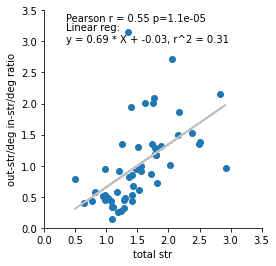

In [15]:
in_deg, out_deg, total_deg = bc.degree.degrees_dir(conn_mat)

in_str, out_str, total_str = bc.degree.strengths_dir(conn_mat)
fig, ax = plt.subplots()
norm_str_ratio = np.divide(np.divide(out_str, out_deg), np.divide(in_str, in_deg))
im = ax.scatter(total_str, norm_str_ratio, color="tab:blue")
ax.set_xlim(0, 3.5)
ax.set_ylim(0, 3.5)
ax.set_xlabel('total str')
ax.set_ylabel('out-str/deg in-str/deg ratio')

sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
annot_reg(total_str, norm_str_ratio, reg_line_color="silver")

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*1)

Text(0.5, 1.0, 'out-str/deg in-str/deg ratio')

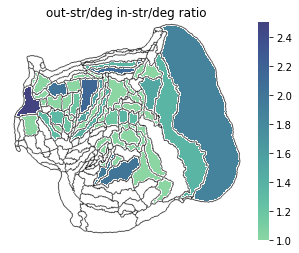

In [16]:
fig, ax, cb = plot_flatmap(norm_str_ratio, cmap=cmap_seq2, vmin=1, vmax=2.5)
plt.title('out-str/deg in-str/deg ratio')